In [30]:
import cv2 as cv
from matplotlib import pyplot as plt
import matplotlib
import numpy as np

In [31]:
matplotlib.rcParams["figure.figsize"] = (25, 12)

In [32]:
img = cv.imread("2019-09-02.png")

hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
h, s, v = cv.split(img)

In [33]:
black = cv.inRange(hsv, np.array([0, 0, 0]), np.array([5, 208, 17]))
not_black = cv.bitwise_not(black)

In [34]:
kernel = np.ones((3,3),np.uint8)

def denoise(i):
    opening = cv.morphologyEx(i, cv.MORPH_OPEN, kernel)
    closing = cv.morphologyEx(i, cv.MORPH_CLOSE, kernel)
    return closing

In [35]:
kernel

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8)

In [36]:
yellow_empty = denoise(cv.inRange(hsv, np.array([27, 255, 17]), np.array([34, 255, 29])))
yellow_fill = denoise(cv.inRange(hsv, np.array([27, 255, 84]), np.array([33, 255, 129])))
yellow = cv.bitwise_or(yellow_empty, yellow_fill)
cv.imwrite("y.png", yellow)

True

In [37]:
red_fill = denoise(cv.inRange(hsv, np.array([5, 148, 90]), np.array([9, 159, 140])))
red_empty = denoise(cv.inRange(hsv, np.array([3, 191, 18]), np.array([9, 211, 33])))
red = cv.bitwise_or(red_empty, red_fill)

In [38]:
template = cv.imread("template.png", 0)

In [39]:
com = cv.bitwise_or(red, yellow)
res = cv.matchTemplate(com, template, cv.TM_CCORR_NORMED)

True

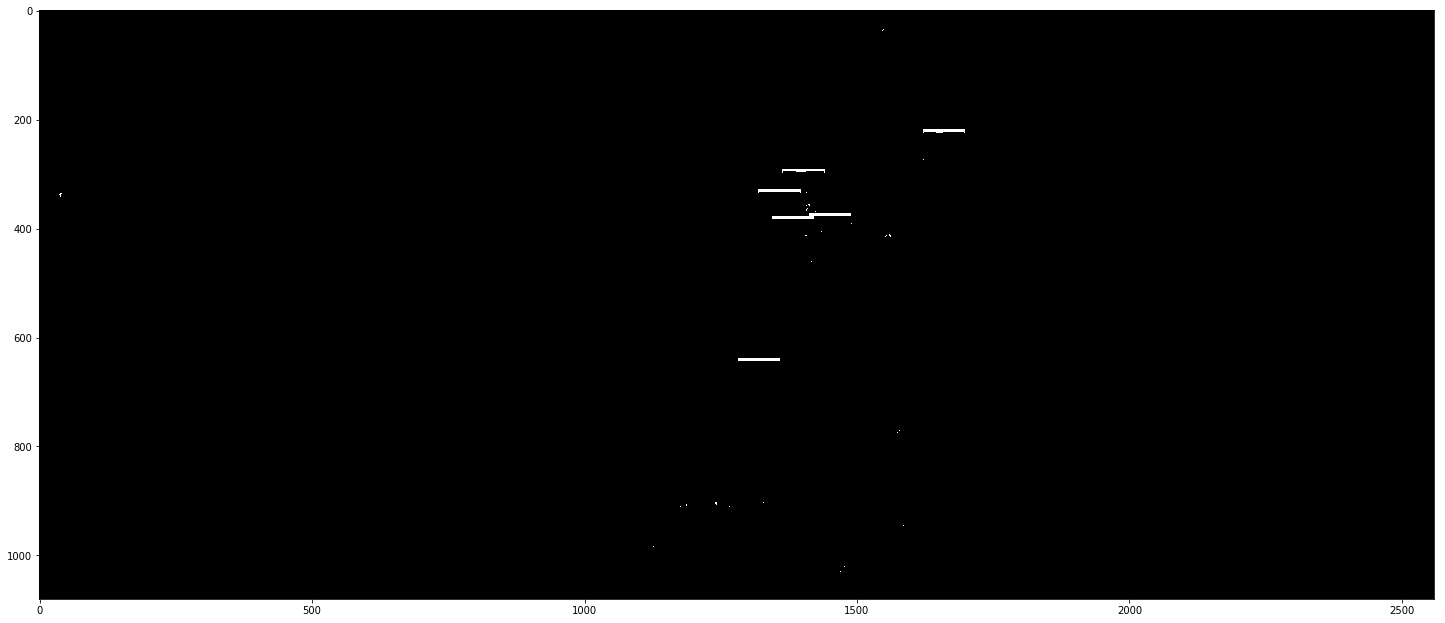

In [40]:
plt.imshow(com, cmap='gray', vmin=0, vmax=255)
cv.imwrite("com.png", com)

True

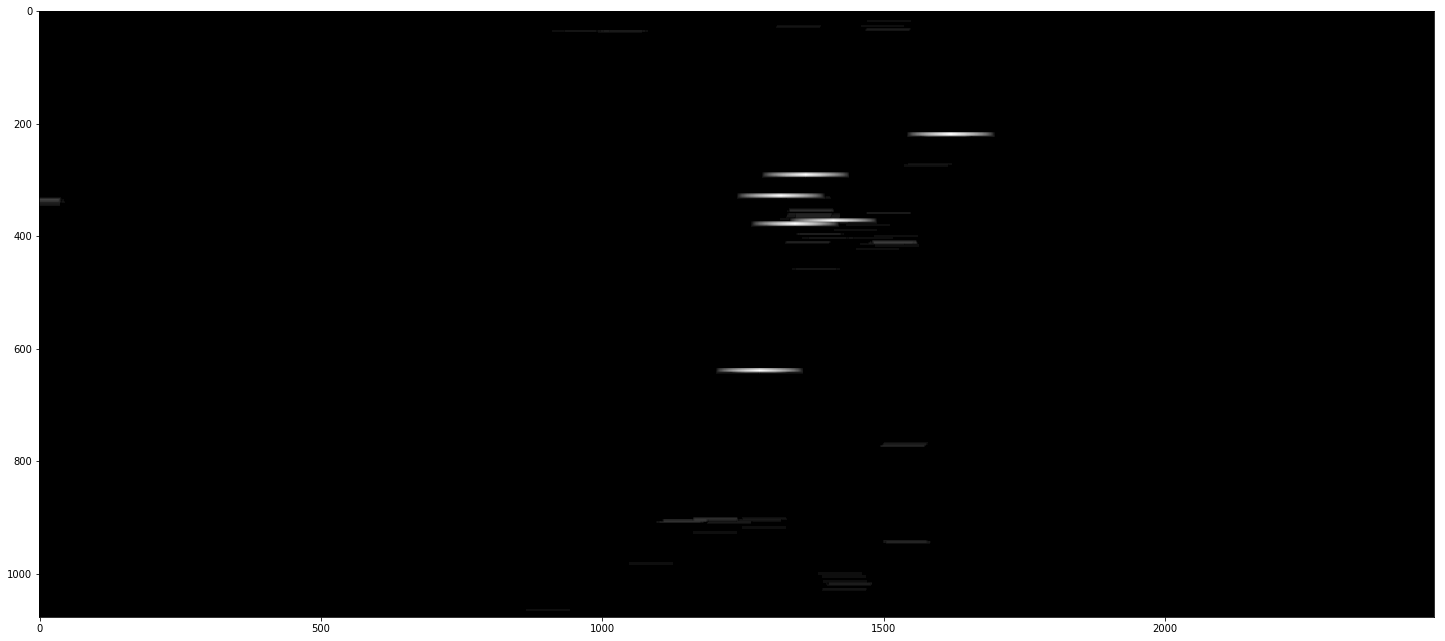

In [41]:
plt.imshow(res, cmap='gray', vmin=0, vmax=1)
cv.imwrite("res.png", (res * 255).astype('uint8'))

In [42]:
w, h = template.shape[::-1]
img_cpy = img.copy()
threshold = 0.95
loc = np.where(res >= threshold)
count = 0
mask = np.zeros(img_cpy.shape[:2], np.uint32)
dup = {}

for i, pt in enumerate(zip(*loc[::-1])):
    check = mask[pt[1] + int(h/2), pt[0] + int(w/2)]
    if check == 0:
        mask[pt[1]:pt[1]+h, pt[0]:pt[0]+w] = i + 1
        dup[i+1] = [pt]
    else:
        dup[check].append(pt)
# cv.rectangle(img_cpy, pt, (pt[0] + w-1, pt[1] + h-1), (0,255,0), 1)

det = []
for key, value in dup.items():
    pt = tuple(np.array(value, np.uint32).mean(axis=0).astype(np.uint32))
    cv.rectangle(img_cpy, pt, (pt[0] + w-1, pt[1] + h-1), (0,255,0), 1)
    det.append(pt)
    count += 1

print("Found {} in total!".format(count))
cv.imwrite('res.png',img_cpy)

Found 6 in total!


True

In [43]:
det

[(1620, 219), (1362, 291), (1318, 328), (1411, 372), (1343, 378), (1280, 638)]

In [44]:
count = 0
mask = np.zeros(img_cpy.shape[:2], np.uint32)
dup = {}

for i in range(len(res)):
    for j in range(len(res[i])):
        if res[i][j] > 0.95:
            check = mask[i + int(h/2), j + int(w/2)]
            if check == 0:
                count += 1
                mask[i:i+h, j:j+w] = count
                dup[count] = (i, j, 1)
            else:
                dup[check] = (dup[check][0] + i, dup[check][1] + j, dup[check][2] + 1)

det = []
for key, value in dup.items():
    det.append((value[1] // value[2], value[0] // value[2]))
det

[(1620, 219), (1362, 291), (1318, 328), (1411, 372), (1343, 378), (1280, 638)]

In [45]:
fill = cv.bitwise_or(red_fill, yellow_fill)
empty = cv.bitwise_or(red_empty, yellow_empty)

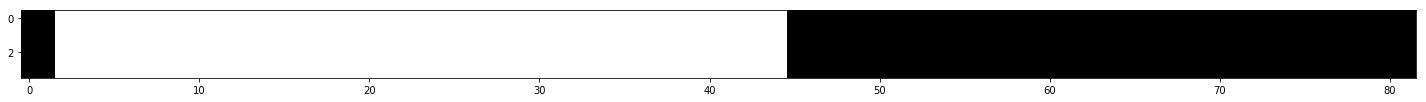

In [46]:
plt.imshow(fill[det[1][1]:det[1][1]+h, det[1][0]:det[1][0]+w], cmap='gray', vmin=0, vmax=255)

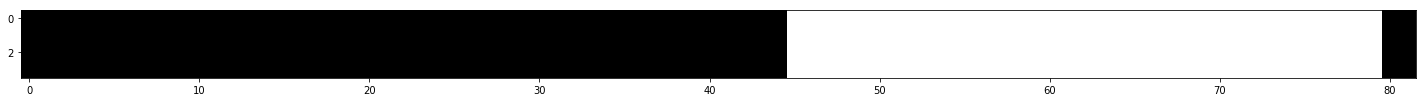

In [523]:
plt.imshow(empty[det[1][1]:det[1][1]+h, det[1][0]:det[1][0]+w], cmap='gray', vmin=0, vmax=255)

In [524]:
creep_health = []
bar_w, bar_h = w - 4, h
for p_x, p_y in det:
    bar_x, bar_y = p_x + 2, p_y
    bar_fill = fill[bar_y:bar_y+bar_h,bar_x:bar_x+bar_w]
    bar_empty = empty[bar_y:bar_y+bar_h,bar_x:bar_x+bar_w]
    health = cv.countNonZero(bar_fill) / bar_fill.size
    lost = cv.countNonZero(bar_empty) / bar_empty.size
    unknown = (cv.countNonZero(bar_fill) + cv.countNonZero(bar_empty)) / bar_fill.size
    creep_health.append((health, lost, unknown))

In [525]:
creep_health

[(0.47435897435897434, 0.5256410256410257, 1.0),
 (0.5512820512820513, 0.44871794871794873, 1.0),
 (0.07692307692307693, 0.9230769230769231, 1.0),
 (0.358974358974359, 0.6410256410256411, 1.0),
 (0.8205128205128205, 0.1794871794871795, 1.0),
 (1.0, 0.0, 1.0)]

In [532]:
health = [550 * c[0] for c in creep_health]
health

[260.8974358974359,
 303.20512820512823,
 42.30769230769231,
 197.43589743589743,
 451.28205128205127,
 550.0]

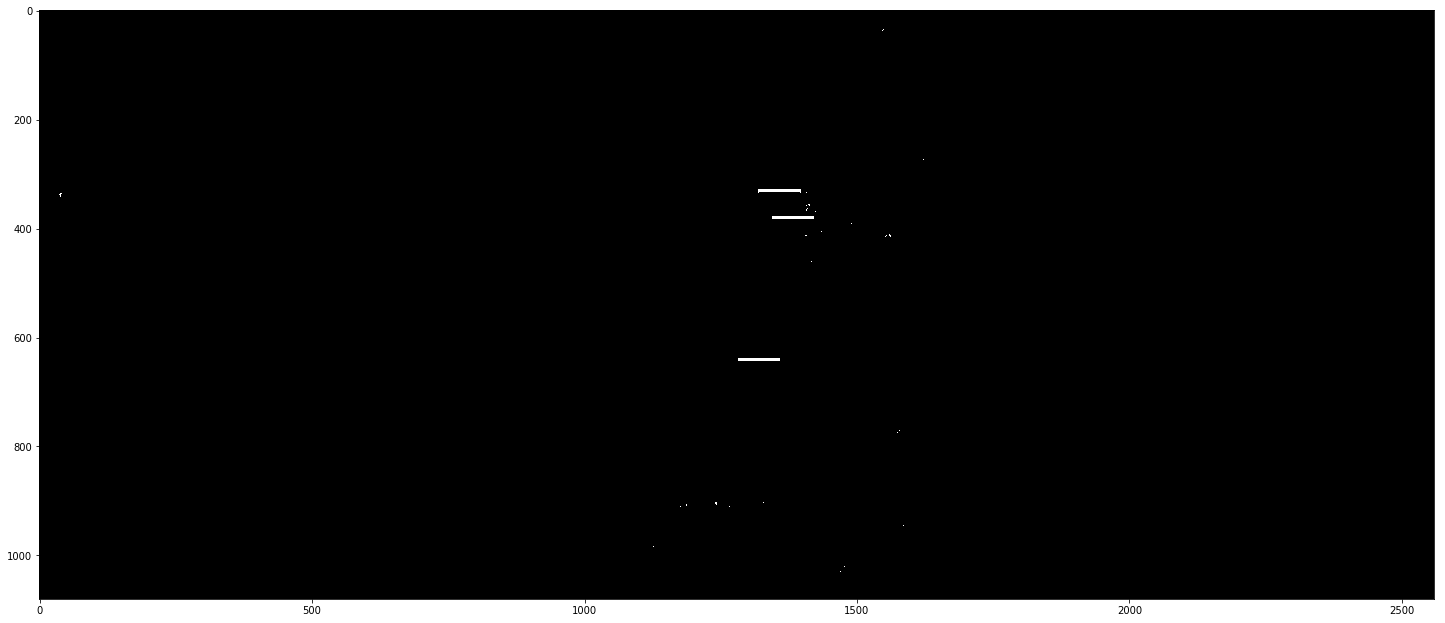

In [526]:
bar_fill = fill[det[2][1]:det[2][1]+bar_h, det[2][0]+2:det[2][0]+2+bar_w]
plt.imshow(red, cmap='gray', vmin=0, vmax=255)

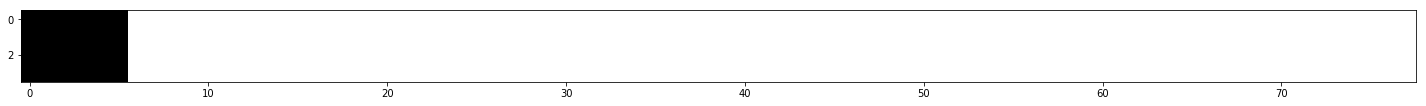

In [527]:
bar_empty = empty[det[2][1]:det[2][1]+bar_h, det[2][0]+2:det[2][0]+2+bar_w]
plt.imshow(bar_empty, cmap='gray', vmin=0, vmax=255)

In [528]:
img = cv.imread("2019-09-02.png")
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
h, s, v = cv.split(hsv)